In [12]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt 
from ransac import *

In [24]:
def imageStitching(left_img,right_img):
    #初始化sift算子
    img1 = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    # 提取特征点和坐标位置
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    # 寻找对应的匹配点
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2, k=2)
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)
    good_2 = np.expand_dims(good, 1)
    #绘出特征点之间的连线
    matching = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good_2,None, flags=2)
    plt.imshow(matching),plt.show()
    if len(good)>4:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,2)
        #利用ransac算法估计单应性矩阵和内点标记掩模
        model,mask = ransanc(src_pts,dst_pts,maxiters=2000,p=0.99,th=0.5)
        #model_v, mask_v = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        #利用估计的单应性矩阵变换原始图像
        shift = np.array([[1.0, 0, img2.shape[1]], [0, 1.0, 0], [0, 0, 1.0]])
        # 加入平移变换
        M = np.dot(shift, model.T)
        wrap = cv2.warpPerspective(left_img, M, (img1.shape[1]+img2.shape[1] , max(img1.shape[0],img2.shape[0])))
        #组合透视变换图像和利用ransanc估计的单应性矩阵变换后的图像,便于对比显示
        wrap[0:img2.shape[0], img2.shape[1]:] = right_img
        #绘出经过ransanc算法筛选后的内点连线
        matchfinal = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good_2[mask>0,],None, flags=2)
        plt.imshow(matchfinal),plt.show()
        rows, cols,_ = np.where(wrap!=0)
        min_row, max_row = min(rows), max(rows) +1
        min_col, max_col = min(cols), max(cols) +1
        result = wrap[min_row:max_row,min_col:max_col]#去除黑色无用部分
    return result

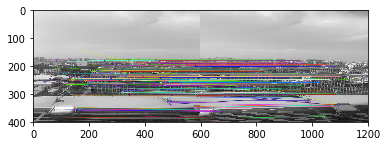

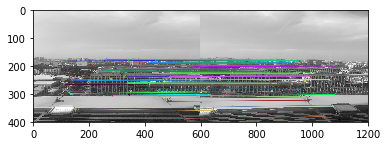

In [26]:
#利用两幅图像进行测试
left_img = cv2.imread("left.jpg")
left_img = cv2.resize(left_img, (600, 400))
right_img = cv2.imread("right.jpg")
right_img = cv2.resize(right_img, (600, 400))
image = imageStitching(left_img,right_img)
cv2.imshow("imageStitching", image)
key = cv2.waitKey(0)
if key == 27:
    cv2.destroyAllWindows()

## 结论

利用自行编写的ransac算法和sift特征进行了图像拼接实验,实验图像选取答疑课程老师提供的左右两幅图像.结果显示实验效果较为理想,但是偶尔会有跑飞的情况,估计是在实现ransac算法时,某些数值计算过程中可能会导致溢出,但是这里不进行详细排查,因为重点在于掌握算法流程.